In [140]:
import datetime

import pandas as pd
import pyarrow as pa
import numpy as np
from utils import load_saved_data, get_connection, get_data
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM, Normality
from hierarchicalforecast.utils import aggregate

In [188]:
# df = load_saved_data()
# conn = get_connection()
# df = get_data(conn, 2018, 2018, 2_000_000, 0)
df = pd.read_feather("../data/2018.feather")



In [189]:
df.describe()

,created_date,closed_date,resolution_action_updated_date,latitude,longitude,due_date
count,2000000,1965900,1983912,1.854231e+06,1.854231e+06,913148
mean,2018-08-22 09:45:50.460096512,2018-09-09 20:51:52.718702336,2018-09-09 12:56:10.453158144,4.072587e+01,-7.392462e+01,2018-09-02 06:03:26.296805376
min,2018-04-13 18:06:41,2007-12-04 00:00:00,2013-05-17 00:00:00,4.049895e+01,-7.425495e+01,2018-04-13 19:07:03
25%,2018-06-19 00:18:42.750000128,2018-06-26 11:17:00,2018-06-26 16:39:59.249999872,4.066430e+01,-7.397041e+01,2018-06-24 05:16:26.249999872
50%,2018-08-22 15:04:00,2018-09-02 08:50:00,2018-09-03 08:47:33,4.071663e+01,-7.392741e+01,2018-08-27 10:05:32
75%,2018-10-24 22:29:17.250000128,2018-11-06 15:55:19.500000,2018-11-07 10:52:22,4.079664e+01,-7.387562e+01,2018-10-30 09:39:18.249999872
max,2019-01-31 14:56:00,2209-01-02 00:00:00,2024-02-12 11:40:59,4.091294e+01,-7.370038e+01,2022-07-21 02:22:26
std,NaN,NaN,NaN,8.583186e-02,8.448541e-02,NaN


In [190]:
df[["latitude","borough"]].describe(include='all')

,latitude,borough
count,1854231.0,1999173
unique,<NA>,6
top,<NA>,BROOKLYN
freq,<NA>,635678
mean,40.725866,NaN
std,0.085832,NaN
min,40.498949,NaN
25%,40.664304,NaN
50%,40.716628,NaN
75%,40.796643,NaN


In [192]:
df[df["latitude"].isnull()]["borough"].unique()


<ArrowStringArray>
[       'QUEENS',      'BROOKLYN',         'BRONX',     'MANHATTAN',
   'Unspecified', 'STATEN ISLAND',            <NA>]
Length: 7, dtype: string

In [200]:
df[(df["borough"]=="Unspecified") &  (df["latitude"].notnull())].count()

created_date                      2287
closed_date                       2285
agency                            2287
complaint_type                    2287
status                            2287
resolution_action_updated_date    2284
borough                           2287
descriptor                        2272
resolution_description            2272
incident_zip                      2144
city                              2251
latitude                          2287
longitude                         2287
due_date                          1814
bbl                                 40
dtype: int64

In [202]:
df[(df["borough"]=="Unspecified") &  (df["latitude"].isnull()) & (df["incident_zip"].isnull())].count()


created_date                      22943
closed_date                       20878
agency                            22943
complaint_type                    22943
status                            22943
resolution_action_updated_date    12127
borough                           22943
descriptor                        22929
resolution_description            22910
incident_zip                          0
city                                  1
latitude                              0
longitude                             0
due_date                          12806
bbl                                   0
dtype: int64

In [142]:
df = df[df["closed_date"]>df["created_date"]]

In [143]:
df["hours_to_complete"] =  pd.to_datetime(df["closed_date"]) - pd.to_datetime(df["created_date"])

In [144]:
# time_to_complete = pd.to_datetime(df["hours_to_complete"])
df['hours_to_complete'] = df["hours_to_complete"].astype("int64")//(3.6e12)
# df= df.drop("hours_to_update", axis=1)
# df = df.drop(df[df["hours_to_complete"]<0].index, axis=0)

In [145]:
df['hours_to_complete']

121           1.0
122           1.0
123          98.0
124        1064.0
125         122.0
            ...  
1999995       4.0
1999996       1.0
1999997       2.0
1999998     567.0
1999999     567.0
Name: hours_to_complete, Length: 1886370, dtype: float64

<Axes: title={'center': 'Number of Unclosed Requests by Agency'}, xlabel='Agency', ylabel='Unclosed Request Count'>

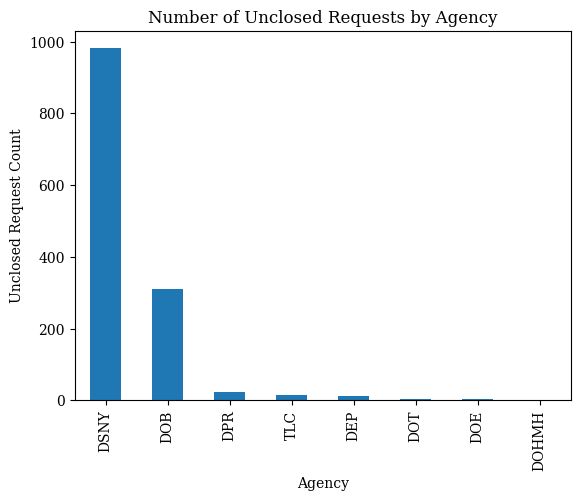

In [146]:
unclosed = df[df["status"]!="Closed"]["agency"].value_counts()
unclosed.plot.bar(title="Number of Unclosed Requests by Agency", xlabel="Agency", ylabel="Unclosed Request Count")

In [147]:
# cl_hr_1 = df["closed_date"].groupby([df["closed_date"].dt.date, df["closed_date"].dt.hour]).value_counts().cumsum()
# conver to hours
# create cumulative sum by summing value count by date for closed date and created date
# subtract the series of cumsums from each other to get number of open per hour

In [148]:
df.sort_values("created_date",ascending=True,axis=0,ignore_index=True,inplace=True)

In [149]:
cr_hr_1 = df["created_date"].groupby([df["created_date"].dt.date, df["created_date"].dt.hour]).count().cumsum()
cr_hr_1.index.set_names(["date", "hour"], inplace=True)

cl_hr_1 = df["closed_date"].groupby([df["closed_date"].dt.date, df["closed_date"].dt.hour]).count().cumsum()
cl_hr_1.index.set_names(["date", "hour"], inplace=True)

In [150]:
df = df.set_index([df["created_date"].dt.date, df["created_date"].dt.hour])
df["open"] = cr_hr_1-cl_hr_1
df.reset_index(drop=True,inplace=True)

In [151]:
cr_hr_1 = df["created_date"].groupby([
    df["created_date"].dt.date,
    df["created_date"].dt.hour,
    df["agency"],
    df["borough"]
    ]).count().cumsum()
cr_hr_1.index.set_names(["date", "hour", "agency", "borough"], inplace=True)

cl_hr_1 = df["closed_date"].groupby([
    df["closed_date"].dt.date,
    df["closed_date"].dt.hour,
    df["agency"],
    df["borough"]
    ]).count().cumsum()
cl_hr_1.index.set_names(["date", "hour", "agency", "borough"], inplace=True)
df = df.set_index([df["created_date"].dt.date, df["created_date"].dt.hour,"agency", "borough"])
df["open_ag_br"] = cr_hr_1-cl_hr_1
# df.reset_index()


In [152]:
df.reset_index(["agency","borough"], inplace=True)
df.reset_index(drop=True,inplace=True)
df

,agency,borough,created_date,closed_date,complaint_type,status,resolution_action_updated_date,descriptor,resolution_description,incident_zip,city,latitude,longitude,due_date,bbl,hours_to_complete,open,open_ag_br
0,HPD,BRONX,2018-04-13 18:06:41,2018-05-07 09:56:32,PAINT/PLASTER,Closed,2018-05-07 09:56:32,WALL,The Department of Housing Preservation and Dev...,10474,BRONX,40.815786,-73.887149,<NA>,2027630149,567.0,234,<NA>
1,HPD,BRONX,2018-04-13 18:06:41,2018-05-07 09:56:32,UNSANITARY CONDITION,Closed,2018-05-07 09:56:32,PESTS,The Department of Housing Preservation and Dev...,10474,BRONX,40.815786,-73.887149,<NA>,2027630149,567.0,234,<NA>
2,NYPD,MANHATTAN,2018-04-13 18:06:46,2018-04-13 20:24:43,Noise - Street/Sidewalk,Closed,2018-04-13 20:24:43,Loud Music/Party,The Police Department responded to the complai...,10035,NEW YORK,40.807463,-73.940741,2018-04-14 02:06:46,1017510066,2.0,234,<NA>
3,DHS,BRONX,2018-04-13 18:07:03,2018-04-13 19:44:21,Homeless Person Assistance,Closed,2018-04-13 19:44:21,<NA>,The mobile outreach response team offered serv...,10469,BRONX,40.870897,-73.847059,2018-04-13 19:07:03,2047590034,1.0,234,<NA>
4,NYPD,BRONX,2018-04-13 18:07:13,2018-04-13 22:15:13,Noise - Residential,Closed,2018-04-13 22:15:13,Loud Music/Party,The Police Department responded to the complai...,10458,BRONX,40.867220,-73.885540,2018-04-14 02:07:13,2032840039,4.0,234,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886365,HPD,MANHATTAN,2018-12-31 23:58:51,2019-01-06 02:05:33,WATER LEAK,Closed,2019-01-06 02:05:33,SLOW LEAK,The Department of Housing Preservation and Dev...,10024,NEW YORK,40.785190,-73.971187,<NA>,1011990015,122.0,90415,<NA>
1886366,HPD,BROOKLYN,2018-12-31 23:58:53,2019-01-05 02:04:57,HEAT/HOT WATER,Closed,2019-01-05 02:04:57,APARTMENT ONLY,The Department of Housing Preservation and Dev...,11203,BROOKLYN,40.649257,-73.926218,<NA>,3047250025,98.0,90415,<NA>
1886367,HPD,BROOKLYN,2018-12-31 23:58:53,2019-02-14 08:52:27,UNSANITARY CONDITION,Closed,2019-02-14 08:52:27,PESTS,The Department of Housing Preservation and Dev...,11203,BROOKLYN,40.649257,-73.926218,<NA>,3047250025,1064.0,90415,<NA>
1886368,NYPD,MANHATTAN,2018-12-31 23:59:29,2019-01-01 01:24:22,Noise - Residential,Closed,2019-01-01 01:24:22,Loud Music/Party,The Police Department responded to the complai...,10019,NEW YORK,40.767918,-73.991726,2019-01-01 07:59:29,1010827501,1.0,90415,90339


In [153]:
cr_hr_1 = df["created_date"].groupby([
    df["created_date"].dt.date,
    df["created_date"].dt.hour,
    df["agency"],
    ]).count().cumsum()
cr_hr_1.index.set_names(["date", "hour", "agency"], inplace=True)

cl_hr_1 = df["closed_date"].groupby([
    df["closed_date"].dt.date,
    df["closed_date"].dt.hour,
    df["agency"],
    ]).count().cumsum()
cl_hr_1.index.set_names(["date", "hour", "agency"], inplace=True)

df = df.set_index([df["created_date"].dt.date, df["created_date"].dt.hour,"agency"])
df["open_ag"] = cr_hr_1-cl_hr_1


In [154]:
df.reset_index("agency", inplace=True)
df.reset_index(drop=True,inplace=True)
df

,agency,borough,created_date,closed_date,complaint_type,status,resolution_action_updated_date,descriptor,resolution_description,incident_zip,city,latitude,longitude,due_date,bbl,hours_to_complete,open,open_ag_br,open_ag
0,HPD,BRONX,2018-04-13 18:06:41,2018-05-07 09:56:32,PAINT/PLASTER,Closed,2018-05-07 09:56:32,WALL,The Department of Housing Preservation and Dev...,10474,BRONX,40.815786,-73.887149,<NA>,2027630149,567.0,234,<NA>,<NA>
1,HPD,BRONX,2018-04-13 18:06:41,2018-05-07 09:56:32,UNSANITARY CONDITION,Closed,2018-05-07 09:56:32,PESTS,The Department of Housing Preservation and Dev...,10474,BRONX,40.815786,-73.887149,<NA>,2027630149,567.0,234,<NA>,<NA>
2,NYPD,MANHATTAN,2018-04-13 18:06:46,2018-04-13 20:24:43,Noise - Street/Sidewalk,Closed,2018-04-13 20:24:43,Loud Music/Party,The Police Department responded to the complai...,10035,NEW YORK,40.807463,-73.940741,2018-04-14 02:06:46,1017510066,2.0,234,<NA>,233
3,DHS,BRONX,2018-04-13 18:07:03,2018-04-13 19:44:21,Homeless Person Assistance,Closed,2018-04-13 19:44:21,<NA>,The mobile outreach response team offered serv...,10469,BRONX,40.870897,-73.847059,2018-04-13 19:07:03,2047590034,1.0,234,<NA>,29
4,NYPD,BRONX,2018-04-13 18:07:13,2018-04-13 22:15:13,Noise - Residential,Closed,2018-04-13 22:15:13,Loud Music/Party,The Police Department responded to the complai...,10458,BRONX,40.867220,-73.885540,2018-04-14 02:07:13,2032840039,4.0,234,149,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886365,HPD,MANHATTAN,2018-12-31 23:58:51,2019-01-06 02:05:33,WATER LEAK,Closed,2019-01-06 02:05:33,SLOW LEAK,The Department of Housing Preservation and Dev...,10024,NEW YORK,40.785190,-73.971187,<NA>,1011990015,122.0,90415,<NA>,<NA>
1886366,HPD,BROOKLYN,2018-12-31 23:58:53,2019-01-05 02:04:57,HEAT/HOT WATER,Closed,2019-01-05 02:04:57,APARTMENT ONLY,The Department of Housing Preservation and Dev...,11203,BROOKLYN,40.649257,-73.926218,<NA>,3047250025,98.0,90415,<NA>,<NA>
1886367,HPD,BROOKLYN,2018-12-31 23:58:53,2019-02-14 08:52:27,UNSANITARY CONDITION,Closed,2019-02-14 08:52:27,PESTS,The Department of Housing Preservation and Dev...,11203,BROOKLYN,40.649257,-73.926218,<NA>,3047250025,1064.0,90415,<NA>,<NA>
1886368,NYPD,MANHATTAN,2018-12-31 23:59:29,2019-01-01 01:24:22,Noise - Residential,Closed,2019-01-01 01:24:22,Loud Music/Party,The Police Department responded to the complai...,10019,NEW YORK,40.767918,-73.991726,2019-01-01 07:59:29,1010827501,1.0,90415,90339,90412


In [155]:
cr_hr_1 = df["created_date"].groupby([
    df["created_date"].dt.date,
    df["created_date"].dt.hour,
    df["borough"]
    ]).count().cumsum()
cr_hr_1.index.set_names(["date", "hour", "borough"], inplace=True)

cl_hr_1 = df["closed_date"].groupby([
    df["closed_date"].dt.date,
    df["closed_date"].dt.hour,
    df["borough"]
    ]).count().cumsum()
cl_hr_1.index.set_names(["date", "hour", "borough"], inplace=True)

df = df.set_index([df["created_date"].dt.date, df["created_date"].dt.hour, "borough"])
df["open_br"] = cr_hr_1-cl_hr_1


In [156]:
df.reset_index("borough", inplace=True)
df.reset_index(drop=True,inplace=True)

In [157]:
# df.dropna(axis=0,inplace=True)

In [158]:
df = df.dropna(axis=0)

In [159]:
df

,borough,agency,created_date,closed_date,complaint_type,status,resolution_action_updated_date,descriptor,resolution_description,incident_zip,city,latitude,longitude,due_date,bbl,hours_to_complete,open,open_ag_br,open_ag,open_br
4,BRONX,NYPD,2018-04-13 18:07:13,2018-04-13 22:15:13,Noise - Residential,Closed,2018-04-13 22:15:13,Loud Music/Party,The Police Department responded to the complai...,10458,BRONX,40.867220,-73.885540,2018-04-14 02:07:13,2032840039,4.0,234,149,233,40
6,BRONX,NYPD,2018-04-13 18:07:23,2018-04-14 00:14:20,Noise - Street/Sidewalk,Closed,2018-04-14 00:14:20,Loud Music/Party,The Police Department responded to the complai...,10453,BRONX,40.847798,-73.913419,2018-04-14 02:07:23,2028610063,6.0,234,149,233,40
13,QUEENS,NYPD,2018-04-13 18:07:51,2018-04-13 20:13:37,Blocked Driveway,Closed,2018-04-13 20:13:37,No Access,The Police Department issued a summons in resp...,11417,OZONE PARK,40.672330,-73.841941,2018-04-14 02:07:51,4115130035,2.0,234,230,233,216
16,BROOKLYN,NYPD,2018-04-13 18:08:30,2018-04-14 11:08:35,Illegal Parking,Closed,2018-04-14 11:08:35,Blocked Hydrant,The Police Department responded to the complai...,11223,BROOKLYN,40.606005,-73.968434,2018-04-14 02:08:30,3066610027,17.0,234,181,233,113
17,BRONX,NYPD,2018-04-13 18:08:41,2018-04-13 18:19:20,Noise - Vehicle,Closed,2018-04-13 18:19:20,Car/Truck Music,The Police Department reviewed your complaint ...,10453,BRONX,40.854215,-73.913613,2018-04-14 02:08:41,2032210088,0.0,234,149,233,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886360,BRONX,NYPD,2018-12-31 23:57:19,2019-01-01 14:55:14,Blocked Driveway,Closed,2019-01-01 14:55:14,No Access,The Police Department responded to the complai...,10462,BRONX,40.846635,-73.865645,2019-01-01 07:57:19,2040500052,14.0,90415,90325,90412,90277
1886361,BRONX,NYPD,2018-12-31 23:57:37,2019-01-01 07:55:39,Blocked Driveway,Closed,2019-01-01 07:55:39,No Access,The Police Department reviewed your complaint ...,10455,BRONX,40.816400,-73.898673,2019-01-01 07:57:37,2027080055,7.0,90415,90325,90412,90277
1886362,MANHATTAN,NYPD,2018-12-31 23:57:51,2019-01-01 02:16:36,Noise - Residential,Closed,2019-01-01 02:16:36,Banging/Pounding,The Police Department responded to the complai...,10033,NEW YORK,40.852222,-73.928982,2019-01-01 07:57:51,1021590029,2.0,90415,90339,90412,90333
1886368,MANHATTAN,NYPD,2018-12-31 23:59:29,2019-01-01 01:24:22,Noise - Residential,Closed,2019-01-01 01:24:22,Loud Music/Party,The Police Department responded to the complai...,10019,NEW YORK,40.767918,-73.991726,2019-01-01 07:59:29,1010827501,1.0,90415,90339,90412,90333


In [160]:
# df.columns = ['borough', 'agency', 'created_date', 'closed_date', 'complaint_type',
#        'status', 'resolution_action_updated_date', 'descriptor',
#        'resolution_description', 'incident_zip', 'city', 'latitude',
#        'longitude', 'due_date', 'bbl', 'hours_to_complete', 'open',
#        'open_ag_br', 'open_ag', 'open_br']
df.columns = [
       'borough', 'agency',
       'ds', 'closed_date',
       'complaint_type', 'status',
       'resolution_action_updated_date', 'descriptor',
       'resolution_description', 'incident_zip',
       'city', 'latitude',
       'longitude', 'due_date',
       'bbl', 'hours_to_complete',
       'open', 'y',
       'open_ag', 'open_br'
]


In [161]:
# heirarchies = [
#     ["borough"],
#     [ "borough","incident_zip"],
#     [ "borough","incident_zip", "agency"],
#     [ "borough","incident_zip", "agency", "complaint_type"],
# ]
hdf = df[df["borough"]!= "Unspecified"]
bdf, H_df, tags = aggregate(
    hdf,
    spec=[["agency","borough"]]
)

In [162]:
bdf

,ds,y
unique_id,,
DCA/BRONX,2018-04-16 12:18:46,9634
DCA/BRONX,2018-04-16 13:59:32,9755
DCA/BRONX,2018-04-16 16:39:48,10624
DCA/BRONX,2018-04-17 12:06:50,12733
DCA/BRONX,2018-04-18 10:59:59,14974
...,...,...
TLC/QUEENS,2018-12-27 09:24:17,89452
TLC/QUEENS,2018-12-27 10:52:26,89574
TLC/STATEN ISLAND,2018-05-02 15:47:38,32248


In [163]:
hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace("ols", nonnegative=True,num_threads=-1),
            # ERM("closed"),
            # BottomUp()
        ]
)


In [164]:


Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]
Y_df

,ds,y
unique_id,,
DCA/BRONX,2018-10-01 14:21:02,84580
DCA/BRONX,2018-10-01 14:33:28,84580
DCA/BRONX,2018-10-01 15:24:22,84689
DCA/BRONX,2018-10-02 15:12:06,84416
DCA/BRONX,2018-10-03 12:25:15,84686
...,...,...
TLC/QUEENS,2018-11-21 11:57:23,92456
TLC/QUEENS,2018-11-21 15:33:19,91920
TLC/QUEENS,2018-11-23 16:23:49,94157


In [165]:

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
)]
sf = StatsForecast(
    models = models,
    freq = 'H',
    df=Y_df,
    n_jobs=-1
    )
sf.fit()

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


StatsForecast(models=[MSTL])

In [170]:
fcts  = sf.forecast(h=1,df=bdf, level=[90])

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [172]:
fcts

,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
DCA/BRONX,2018-12-31 15:11:20,95707.625000,94654.968750,96760.281250
DCA/BROOKLYN,2018-12-31 09:19:12,89382.242188,88584.140625,90180.343750
DCA/MANHATTAN,2018-12-31 16:52:04,91162.359375,90362.531250,91962.195312
DCA/QUEENS,2018-12-31 13:35:21,91870.984375,91060.609375,92681.359375
DCA/STATEN ISLAND,2018-11-30 11:22:46,15744.000000,15743.998047,15744.001953
DFTA/BRONX,2018-12-03 14:08:35,42650.000000,42649.988281,42650.011719
DFTA/BROOKLYN,2018-12-14 11:16:09,30084.513672,30084.509766,30084.519531
DFTA/MANHATTAN,2018-11-29 16:00:07,48759.000000,48745.343750,48772.656250
DFTA/QUEENS,2018-12-18 12:27:30,38849.000000,38848.992188,38849.007812


c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:1316: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:1325: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


TypeError: float() argument must be a string or a real number, not 'NAType'

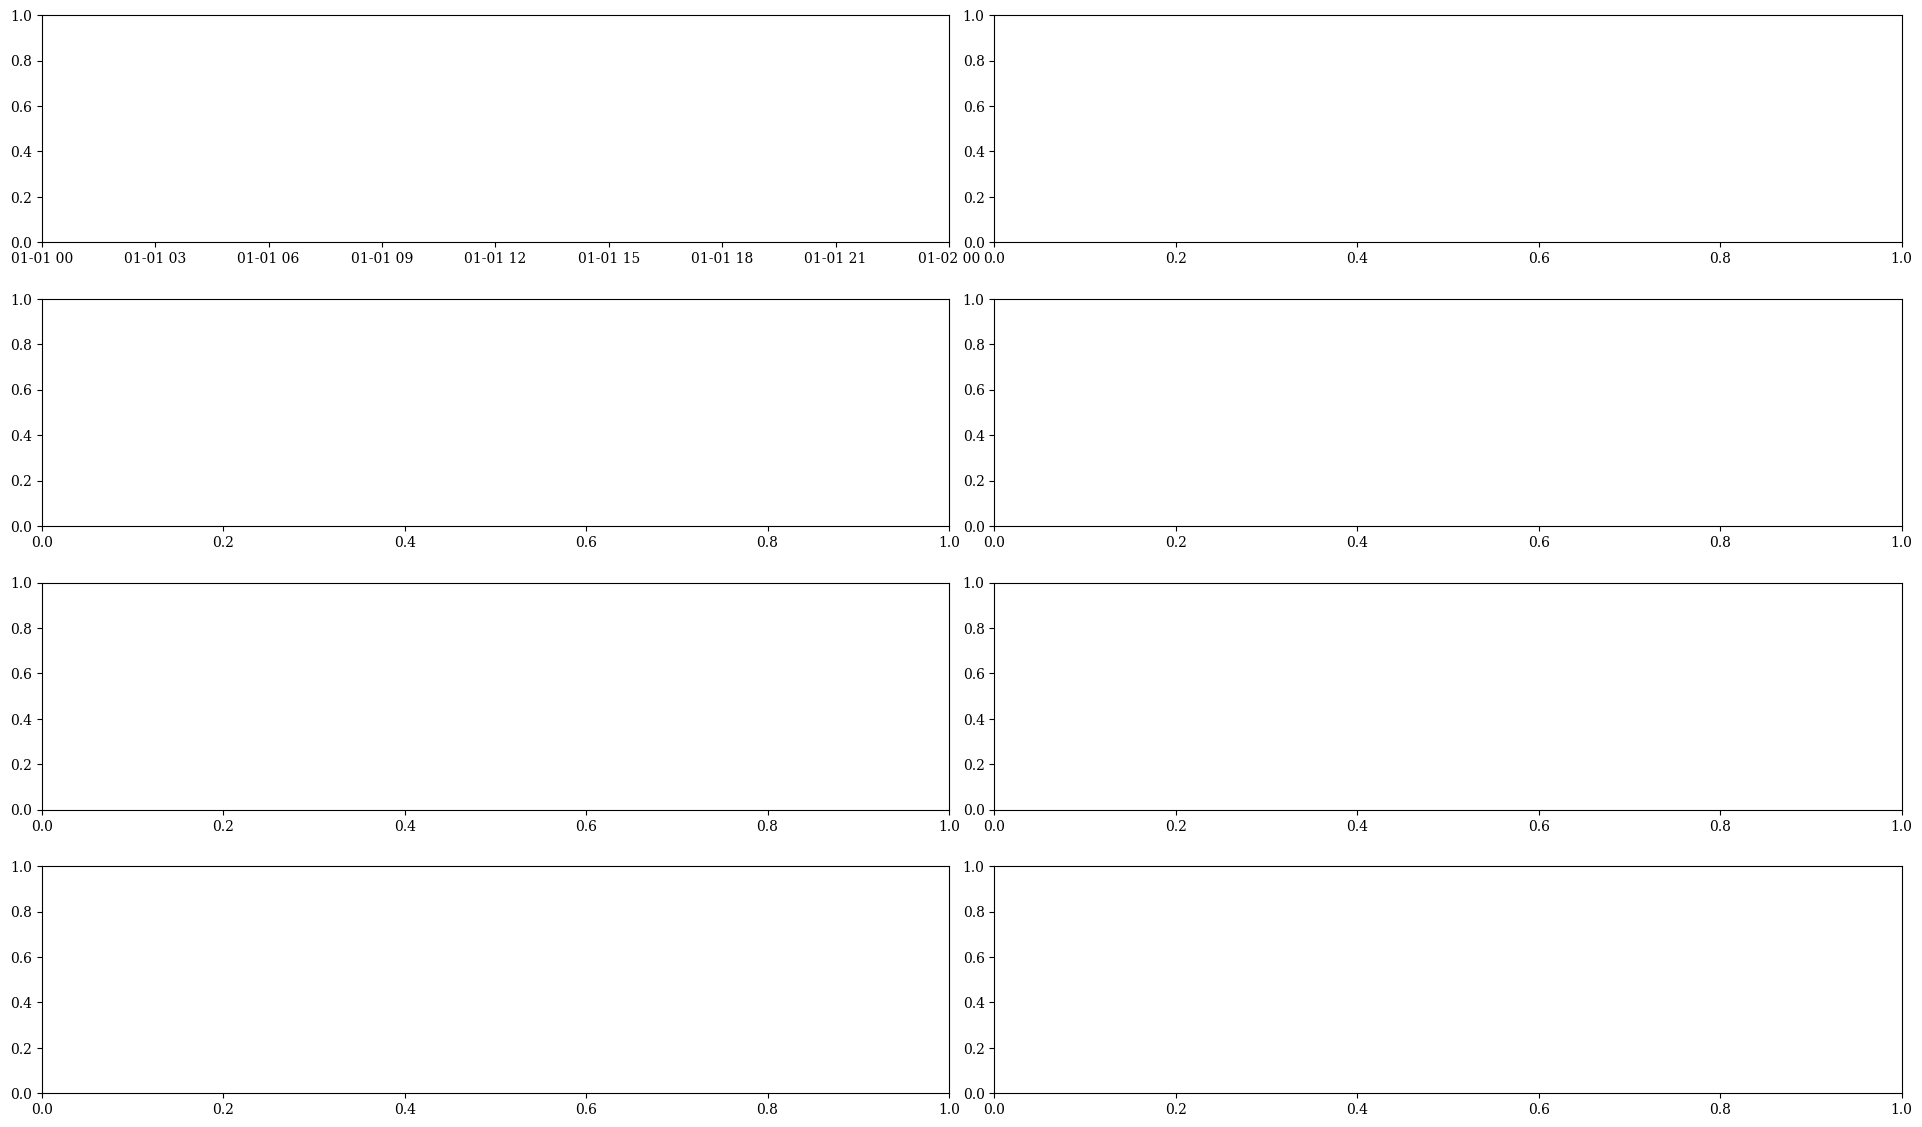

In [176]:
StatsForecast.plot(df=Y_df, forecasts_df=fcts[fcts.index.isin(bdf.index)].fillna(0))